In [ ]:
# Instalar la librería
%pip install yfinance

import yfinance as yf

# Descarga datos del oro (GC=F)
df = yf.download("GC=F", start="2020-09-26", end="2025-09-26", interval="1d")

# Guardar en CSV
df.to_csv("gold_data.csv")
print("Archivo CSV guardado como gold_data.csv")
# a


[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/var/folders/r9/xwlkxv7j0l7dcq4b4vs9c34w0000gn/T/ipykernel_1936/1784743917.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("GC=F", start="2020-09-26", end="2025-09-26", interval="1d")
[*********************100%***********************]  1 of 1 completed

Archivo CSV guardado como gold_data.csv


In [2]:
import yfinance as yf

# Descargar datos históricos del S&P 500 (^GSPC)
sp500 = yf.download("^GSPC", start="2020-01-01", end="2025-09-25", interval="1d")

# Guardar en CSV
sp500.to_csv("sp500.csv")

print("✅ Archivo CSV del S&P 500 guardado como sp500.csv")
print(sp500.head())  # Muestra las primeras filas para verificar


/var/folders/r9/xwlkxv7j0l7dcq4b4vs9c34w0000gn/T/ipykernel_1936/1227420507.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2020-01-01", end="2025-09-25", interval="1d")
[*********************100%***********************]  1 of 1 completed

✅ Archivo CSV del S&P 500 guardado como sp500.csv
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2020-01-02  3257.850098  3258.139893  3235.530029  3244.669922  3459930000
2020-01-03  3234.850098  3246.149902  3222.340088  3226.360107  3484700000
2020-01-06  3246.280029  3246.840088  3214.639893  3217.550049  3702460000
2020-01-07  3237.179932  3244.909912  3232.429932  3241.860107  3435910000
2020-01-08  3253.050049  3267.070068  3236.669922  3238.590088  3726840000


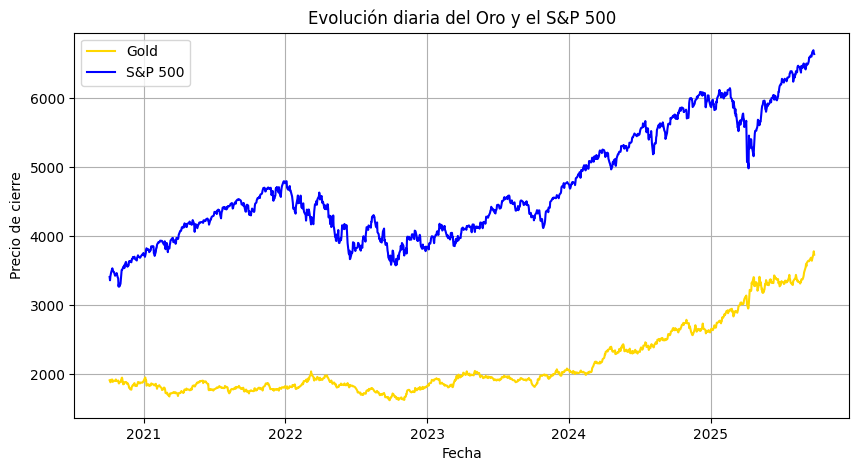

,Date,Gold_Close,SP500_Close,Gold_Return,SP500_Return,Gold_Close_Lag1,SP500_Close_Lag1,Gold_Close_Lag2,SP500_Close_Lag2,Gold_MA5,SP500_MA5,Gold_Volatility_5,SP500_Return_Lag1
0,2020-10-05,1912.500000,3408.600098,0.006473,0.017973,1900.199951,3348.419922,1908.400024,3380.800049,1900.580005,3367.258008,0.007718,-0.009578
1,2020-10-06,1901.099976,3360.969971,-0.005961,-0.013974,1912.500000,3408.600098,1900.199951,3348.419922,1901.939990,3372.358008,0.007561,0.017973
2,2020-10-07,1883.599976,3419.439941,-0.009205,0.017397,1901.099976,3360.969971,1912.500000,3408.600098,1901.159985,3383.645996,0.008696,-0.013974
3,2020-10-08,1888.599976,3446.830078,0.002654,0.008010,1883.599976,3419.439941,1901.099976,3360.969971,1897.199976,3396.852002,0.006448,0.017397
4,2020-10-09,1919.500000,3477.139893,0.016361,0.008794,1888.599976,3446.830078,1883.599976,3419.439941,1901.059986,3422.595996,0.010193,0.008010


In [10]:
import pandas as pd
import plotly.express as px

# === 1. Cargar archivos CSV ===
gold_df = pd.read_csv("gold_data.csv")
sp500_df = pd.read_csv("sp500.csv")

# === 2. Normalizar fechas (indicando que el día está primero) ===
gold_df['Date'] = pd.to_datetime(gold_df['Date'], dayfirst=True)
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'], dayfirst=True)

# === 3. Graficar Precio del Oro ===
fig_gold = px.line(
    gold_df,
    x="Date",
    y="Close",
    title=" Precio del Oro (Gold)",
    labels={"Close": "Precio de Cierre", "Date": "Fecha"},
)
fig_gold.update_traces(line=dict(color="gold"))
fig_gold.show()

# === 4. Graficar S&P 500 ===
fig_sp500 = px.line(
    sp500_df,
    x="Date",
    y="Close",
    title=" Índice S&P 500",
    labels={"Close": "Índice de Cierre", "Date": "Fecha"},
)
fig_sp500.update_traces(line=dict(color="orange"))
fig_sp500.show()

# === 5. Graficar comparativa Oro vs S&P 500 ===
gold_df["Activo"] = "Oro"
sp500_df["Activo"] = "S&P 500"
combined_df = pd.concat([gold_df[["Date", "Close", "Activo"]],
                         sp500_df[["Date", "Close", "Activo"]]])

fig_combined = px.line(
    combined_df,
    x="Date",
    y="Close",
    color="Activo",
    title=" Comparativa Oro vs S&P 500",
    labels={"Close": "Valor", "Date": "Fecha"},
)
fig_combined.show()


In [9]:
# Crear múltiples lags
for lag in [1, 7, 30]:
    df[f'Close_lag{lag}'] = df['Close'].shift(lag)


In [11]:
# Eliminar filas con NaN generadas por lags/diffs
df_clean = df.dropna().reset_index(drop=True)
print(f"Dataset final para modelado: {df_clean.shape[0]} filas")


Dataset final para modelado: 1227 filas


In [12]:
print(df_clean.info())
print(df_clean.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227 entries, 0 to 1226
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, GC=F)    1227 non-null   float64
 1   (High, GC=F)     1227 non-null   float64
 2   (Low, GC=F)      1227 non-null   float64
 3   (Open, GC=F)     1227 non-null   float64
 4   (Volume, GC=F)   1227 non-null   int64  
 5   (Close_lag1, )   1227 non-null   float64
 6   (Close_lag7, )   1227 non-null   float64
 7   (Close_lag30, )  1227 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 76.8 KB
None
Price         Close         High          Low         Open Volume  \
Ticker         GC=F         GC=F         GC=F         GC=F   GC=F   
0       1853.199951  1963.199951  1847.099976  1955.599976    745   
1       1875.400024  1885.300049  1871.199951  1879.300049    276   
2       1860.699951  1878.800049  1855.500000  1878.800049    222   
3       1872.599976  1878.500000 